Using device: cuda
dat shape (neurons × trials): (39209, 5900)

Neuron 386 -------------------------

 Fold 1/5
SAE epoch  20/60 | loss=0.323242
SAE epoch  40/60 | loss=0.023605
SAE epoch  60/60 | loss=0.004952

 Fold 2/5
SAE epoch  20/60 | loss=0.343089
SAE epoch  40/60 | loss=0.024078
SAE epoch  60/60 | loss=0.005103

 Fold 3/5
SAE epoch  20/60 | loss=0.342407
SAE epoch  40/60 | loss=0.023312
SAE epoch  60/60 | loss=0.004713

 Fold 4/5
SAE epoch  20/60 | loss=0.328500
SAE epoch  40/60 | loss=0.024540
SAE epoch  60/60 | loss=0.004750

 Fold 5/5
SAE epoch  20/60 | loss=0.340994
SAE epoch  40/60 | loss=0.023906
SAE epoch  60/60 | loss=0.004755

Neuron 24940 -------------------------

 Fold 1/5
SAE epoch  20/60 | loss=0.333204
SAE epoch  40/60 | loss=0.023439
SAE epoch  60/60 | loss=0.004776

 Fold 2/5
SAE epoch  20/60 | loss=0.331708
SAE epoch  40/60 | loss=0.023260
SAE epoch  60/60 | loss=0.004823

 Fold 3/5
SAE epoch  20/60 | loss=0.333106
SAE epoch  40/60 | loss=0.023433
SAE epoch  6

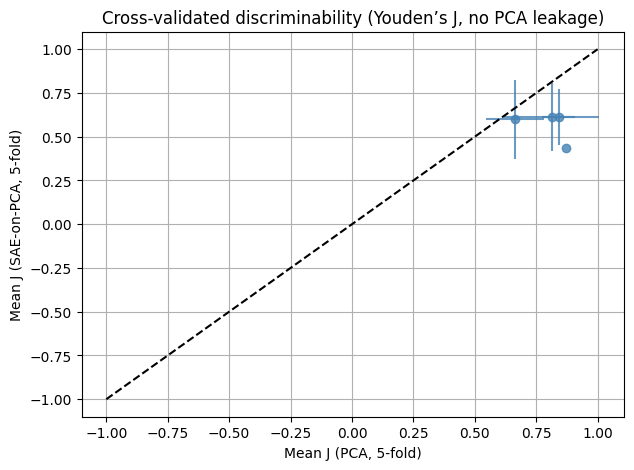

In [3]:
# ================================================================
# 5-FOLD CROSSVALIDATION (NO PCA LEAKAGE) — YOUDEN’S J VERSION
# ================================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve
from skbio.stats.composition import clr
from scipy.special import softmax
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings, pickle

warnings.filterwarnings("ignore")
rng = np.random.default_rng(42)
torch.manual_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ---------------------------------------------------------------
# Load data
# ---------------------------------------------------------------
dat = np.load("/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy")
print("dat shape (neurons × trials):", dat.shape)

path = "/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl"
with open(path, "rb") as f:
    vit_dict = pickle.load(f)["natural_scenes"]

embeddings = np.stack(list(vit_dict))   # (118, 1000)
X = softmax(embeddings, axis=1)
Y_binary = (dat > 0).astype(int)
n_neurons, n_samples = dat.shape
n_images, n_trials = 118, 50
img_ids_full = np.repeat(np.arange(n_images), n_trials)

# ---------------------------------------------------------------
# SAE definition
# ---------------------------------------------------------------
SAE_DIM, SAE_EPOCHS, SAE_BATCH, SAE_LR, SAE_L1 = 100, 60, 256, 1e-3, 1e-3

class SAE(nn.Module):
    def __init__(self, d_in, d_latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_latent), nn.ReLU(inplace=True)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_in)
        )
    def forward(self, x):
        h = self.enc(x)
        return self.dec(h), h

def train_sae(X_train, d_latent=SAE_DIM, epochs=SAE_EPOCHS, batch=SAE_BATCH,
              lr=SAE_LR, l1=SAE_L1):
    d_in = X_train.shape[1]
    model = SAE(d_in, d_latent).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    scaler = StandardScaler().fit(X_train)
    X_std = scaler.transform(X_train)
    dl = DataLoader(TensorDataset(torch.from_numpy(X_std.astype(np.float32))),
                    batch_size=batch, shuffle=True)
    for ep in range(1, epochs+1):
        tot = 0
        for (xb,) in dl:
            xb = xb.to(DEVICE)
            x_hat, h = model(xb)
            loss = mse(x_hat, xb) + l1 * torch.mean(torch.abs(h))
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
        if ep % 20 == 0 or ep == epochs:
            print(f"SAE epoch {ep:3d}/{epochs} | loss={tot/len(dl.dataset):.6f}")
    return model, scaler

@torch.no_grad()
def encode(model, scaler, X):
    X_std = scaler.transform(X)
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    _, h = model(xb)
    return h.cpu().numpy()

# ---------------------------------------------------------------
# Youden’s J helpers
# ---------------------------------------------------------------
def compute_youden_j(y_true, y_pred, img_ids, threshold=0.5):
    """Aggregate by image, then compute Youden’s J = TPR − FPR."""
    df = pd.DataFrame({"img": img_ids, "y": y_true, "p": y_pred})
    agg = df.groupby("img").mean()  # average over trials
    y_bin = (agg["p"] >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(agg["y"], y_bin).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    return tpr - fpr

def compute_youden_j_optimal(y_true, y_pred, img_ids):
    """Safe maximal-Youden's J; returns np.nan if ROC cannot be computed."""
    df = pd.DataFrame({"img": img_ids, "y": y_true, "p": y_pred})
    agg = df.groupby("img").mean()

    # Binarize neural activity
    y_bin = (agg["y"] >= 0.5).astype(int)

    # Skip if all 0 or all 1
    if y_bin.nunique() < 2:
        return np.nan

    # Compute ROC
    fpr, tpr, thr = roc_curve(y_bin, agg["p"])
    j = tpr - fpr
    if len(j) == 0:
        return np.nan
    return np.max(j)



# ---------------------------------------------------------------
# Prepare folds and neurons
# ---------------------------------------------------------------
X_clr = clr(X + 1e-12)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
top_pca_neurons = [386, 24940, 28489, 7800, 10412, 26513, 15930, 25807, 27783, 16929]
records = []

# ---------------------------------------------------------------
# Cross-validation with fold-wise PCA and SAE training
# ---------------------------------------------------------------
for nid in top_pca_neurons:
    y_all = Y_binary[nid]
    j_pca_folds, j_sae_folds = [], []

    print(f"\nNeuron {nid} -------------------------")

    for fold_i, (train_img_idx, test_img_idx) in enumerate(kf.split(np.arange(n_images)), 1):
        print(f"\n Fold {fold_i}/5")

        # PCA trained only on training images
        pca_train = PCA()
        pca_train.fit(X_clr[train_img_idx])
        cum_var = np.cumsum(pca_train.explained_variance_ratio_)
        n_components_90 = np.argmax(cum_var >= 0.90) + 1
        pca = PCA(n_components=n_components_90)
        X_train_pca_unique = pca.fit_transform(X_clr[train_img_idx])
        X_test_pca_unique  = pca.transform(X_clr[test_img_idx])

        # Repeat per trial
        X_train_pca = np.repeat(X_train_pca_unique, n_trials, axis=0)
        X_test_pca  = np.repeat(X_test_pca_unique,  n_trials, axis=0)
        train_mask = np.isin(img_ids_full, train_img_idx)
        test_mask  = np.isin(img_ids_full,  test_img_idx)
        y_train, y_test = y_all[train_mask], y_all[test_mask]
        test_img_ids = img_ids_full[test_mask]

        # Train SAE on PCA(train)
        sae_model, sae_scaler = train_sae(X_train_pca_unique)
        Z_train_unique = encode(sae_model, sae_scaler, X_train_pca_unique)
        Z_test_unique  = encode(sae_model,  sae_scaler, X_test_pca_unique)
        Z_train = np.repeat(Z_train_unique, n_trials, axis=0)
        Z_test  = np.repeat(Z_test_unique,  n_trials, axis=0)

        # Logistic regression: PCA
        log_pca = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
        log_pca.fit(X_train_pca, y_train)
        y_pred_pca = log_pca.predict_proba(X_test_pca)[:, 1]
        j_pca = compute_youden_j_optimal(y_test, y_pred_pca, test_img_ids)
        j_pca_folds.append(j_pca)

        # Logistic regression: SAE
        log_sae = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
        log_sae.fit(Z_train, y_train)
        y_pred_sae = log_sae.predict_proba(Z_test)[:, 1]
        j_sae = compute_youden_j_optimal(y_test, y_pred_sae, test_img_ids)
        j_sae_folds.append(j_sae)

    records.append({
        "neuron_idx": nid,
        "J_PCA_mean": np.nanmean(j_pca_folds),
        "J_PCA_std":  np.nanstd(j_pca_folds),
        "J_SAE_mean": np.nanmean(j_sae_folds),
        "J_SAE_std":  np.nanstd(j_sae_folds),
        "delta_J_mean": np.nanmean(np.array(j_sae_folds) - np.array(j_pca_folds))
    })

# ---------------------------------------------------------------
# Results
# ---------------------------------------------------------------
df_cv_j = pd.DataFrame(records)
print("\n=== 5-Fold Crossvalidated Youden’s J (no PCA leakage) ===")
print(df_cv_j.round(4))

plt.figure(figsize=(7,5))
plt.errorbar(df_cv_j["J_PCA_mean"], df_cv_j["J_SAE_mean"],
             xerr=df_cv_j["J_PCA_std"], yerr=df_cv_j["J_SAE_std"],
             fmt='o', alpha=0.8, color='steelblue')
plt.plot([-1,1],[-1,1],'k--')
plt.xlabel("Mean J (PCA, 5-fold)")
plt.ylabel("Mean J (SAE-on-PCA, 5-fold)")
plt.title("Cross-validated discriminability (Youden’s J, no PCA leakage)")
plt.grid(True)
plt.show()


In [4]:
df_cv_j

,neuron_idx,J_PCA_mean,J_PCA_std,J_SAE_mean,J_SAE_std,delta_J_mean
0,386,0.813241,0.194368,0.610672,0.194411,-0.202569
1,24940,NaN,NaN,NaN,NaN,NaN
2,28489,NaN,NaN,NaN,NaN,NaN
3,7800,NaN,NaN,NaN,NaN,NaN
4,10412,0.662013,0.118134,0.599675,0.225567,-0.062338
5,26513,0.840909,0.068182,0.613636,0.159091,-0.227273
6,15930,NaN,NaN,NaN,NaN,NaN
7,25807,NaN,NaN,NaN,NaN,NaN
8,27783,0.869565,0.000000,0.434783,0.000000,-0.434783
9,16929,NaN,NaN,NaN,NaN,NaN


Using device: cuda
dat shape (neurons × trials): (39209, 5900)

Neuron 386 -------------------------

 Fold 1/5
SAE epoch  20/60 | loss=0.326259
SAE epoch  40/60 | loss=0.023481
SAE epoch  60/60 | loss=0.004953

 Fold 2/5
SAE epoch  20/60 | loss=0.335886
SAE epoch  40/60 | loss=0.024815
SAE epoch  60/60 | loss=0.005045

 Fold 3/5
SAE epoch  20/60 | loss=0.343157
SAE epoch  40/60 | loss=0.025306
SAE epoch  60/60 | loss=0.004928

 Fold 4/5
SAE epoch  20/60 | loss=0.336679
SAE epoch  40/60 | loss=0.024841
SAE epoch  60/60 | loss=0.004832

 Fold 5/5
SAE epoch  20/60 | loss=0.339352
SAE epoch  40/60 | loss=0.024299
SAE epoch  60/60 | loss=0.004752

Neuron 24940 -------------------------

 Fold 1/5
SAE epoch  20/60 | loss=0.331096
SAE epoch  40/60 | loss=0.023810
SAE epoch  60/60 | loss=0.004735

 Fold 2/5
SAE epoch  20/60 | loss=0.340221
SAE epoch  40/60 | loss=0.023896
SAE epoch  60/60 | loss=0.005045

 Fold 3/5
SAE epoch  20/60 | loss=0.325044
SAE epoch  40/60 | loss=0.024209
SAE epoch  6

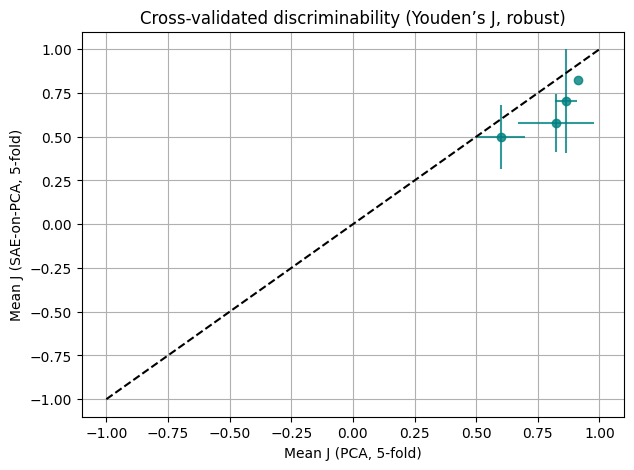

In [5]:
# ================================================================
# 5-FOLD CROSSVALIDATION (NO PCA LEAKAGE) — SAFE YOUDEN’S J VERSION
# ================================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from skbio.stats.composition import clr
from scipy.special import softmax
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings, pickle

warnings.filterwarnings("ignore")
rng = np.random.default_rng(42)
torch.manual_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ---------------------------------------------------------------
# Load data
# ---------------------------------------------------------------
dat = np.load("/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy")
print("dat shape (neurons × trials):", dat.shape)

path = "/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl"
with open(path, "rb") as f:
    vit_dict = pickle.load(f)["natural_scenes"]

embeddings = np.stack(list(vit_dict))   # (118, 1000)
X = softmax(embeddings, axis=1)
Y_binary = (dat > 0).astype(int)
n_neurons, n_samples = dat.shape
n_images, n_trials = 118, 50
img_ids_full = np.repeat(np.arange(n_images), n_trials)

# ---------------------------------------------------------------
# SAE definition
# ---------------------------------------------------------------
SAE_DIM, SAE_EPOCHS, SAE_BATCH, SAE_LR, SAE_L1 = 100, 60, 256, 1e-3, 1e-3

class SAE(nn.Module):
    def __init__(self, d_in, d_latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_latent), nn.ReLU(inplace=True)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_in)
        )
    def forward(self, x):
        h = self.enc(x)
        return self.dec(h), h

def train_sae(X_train, d_latent=SAE_DIM, epochs=SAE_EPOCHS, batch=SAE_BATCH,
              lr=SAE_LR, l1=SAE_L1):
    d_in = X_train.shape[1]
    model = SAE(d_in, d_latent).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    scaler = StandardScaler().fit(X_train)
    X_std = scaler.transform(X_train)
    dl = DataLoader(TensorDataset(torch.from_numpy(X_std.astype(np.float32))),
                    batch_size=batch, shuffle=True)
    for ep in range(1, epochs+1):
        tot = 0
        for (xb,) in dl:
            xb = xb.to(DEVICE)
            x_hat, h = model(xb)
            loss = mse(x_hat, xb) + l1 * torch.mean(torch.abs(h))
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
        if ep % 20 == 0 or ep == epochs:
            print(f"SAE epoch {ep:3d}/{epochs} | loss={tot/len(dl.dataset):.6f}")
    return model, scaler

@torch.no_grad()
def encode(model, scaler, X):
    X_std = scaler.transform(X)
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    _, h = model(xb)
    return h.cpu().numpy()

# ---------------------------------------------------------------
# Robust Youden’s J computation
# ---------------------------------------------------------------
def compute_youden_j_optimal(y_true, y_pred, img_ids):
    """
    Safe maximal Youden’s J (TPR−FPR) per image.
    Returns np.nan only if both classes are missing.
    """
    df = pd.DataFrame({"img": img_ids, "y": y_true, "p": y_pred})
    agg = df.groupby("img").mean()

    # Binarize average neural response across trials
    y_bin = (agg["y"] >= 0.5).astype(int)

    # Skip if only one class present
    if y_bin.nunique() < 2:
        return np.nan

    # Guard: predictions constant or nan
    if np.isnan(agg["p"]).any() or np.std(agg["p"]) == 0:
        return np.nan

    try:
        fpr, tpr, thr = roc_curve(y_bin, agg["p"])
        if len(fpr) == 0:
            return np.nan
        j = tpr - fpr
        return float(np.nanmax(j))
    except Exception as e:
        print(f"ROC computation failed: {e}")
        return np.nan

# ---------------------------------------------------------------
# Prepare folds and neurons
# ---------------------------------------------------------------
X_clr = clr(X + 1e-12)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
top_pca_neurons = [386, 24940, 28489, 7800, 10412, 26513, 15930, 25807, 27783, 16929]
records = []

# ---------------------------------------------------------------
# Cross-validation with fold-wise PCA and SAE training
# ---------------------------------------------------------------
for nid in top_pca_neurons:
    y_all = Y_binary[nid]
    j_pca_folds, j_sae_folds = [], []

    print(f"\nNeuron {nid} -------------------------")

    for fold_i, (train_img_idx, test_img_idx) in enumerate(kf.split(np.arange(n_images)), 1):
        print(f"\n Fold {fold_i}/5")

        # PCA trained only on training images
        pca_train = PCA()
        pca_train.fit(X_clr[train_img_idx])
        cum_var = np.cumsum(pca_train.explained_variance_ratio_)
        n_components_90 = np.argmax(cum_var >= 0.90) + 1
        pca = PCA(n_components=n_components_90)
        X_train_pca_unique = pca.fit_transform(X_clr[train_img_idx])
        X_test_pca_unique  = pca.transform(X_clr[test_img_idx])

        # Repeat per trial
        X_train_pca = np.repeat(X_train_pca_unique, n_trials, axis=0)
        X_test_pca  = np.repeat(X_test_pca_unique,  n_trials, axis=0)
        train_mask = np.isin(img_ids_full, train_img_idx)
        test_mask  = np.isin(img_ids_full,  test_img_idx)
        y_train, y_test = y_all[train_mask], y_all[test_mask]
        test_img_ids = img_ids_full[test_mask]

        # Train SAE on PCA(train)
        sae_model, sae_scaler = train_sae(X_train_pca_unique)
        Z_train_unique = encode(sae_model, sae_scaler, X_train_pca_unique)
        Z_test_unique  = encode(sae_model,  sae_scaler, X_test_pca_unique)
        Z_train = np.repeat(Z_train_unique, n_trials, axis=0)
        Z_test  = np.repeat(Z_test_unique,  n_trials, axis=0)

        # Logistic regression: PCA
        log_pca = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
        log_pca.fit(X_train_pca, y_train)
        y_pred_pca = log_pca.predict_proba(X_test_pca)[:, 1]
        j_pca = compute_youden_j_optimal(y_test, y_pred_pca, test_img_ids)
        j_pca_folds.append(j_pca)

        # Logistic regression: SAE
        log_sae = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
        log_sae.fit(Z_train, y_train)
        y_pred_sae = log_sae.predict_proba(Z_test)[:, 1]
        j_sae = compute_youden_j_optimal(y_test, y_pred_sae, test_img_ids)
        j_sae_folds.append(j_sae)

    records.append({
        "neuron_idx": nid,
        "J_PCA_mean": np.nanmean(j_pca_folds),
        "J_PCA_std":  np.nanstd(j_pca_folds),
        "J_SAE_mean": np.nanmean(j_sae_folds),
        "J_SAE_std":  np.nanstd(j_sae_folds),
        "delta_J_mean": np.nanmean(np.array(j_sae_folds) - np.array(j_pca_folds))
    })

# ---------------------------------------------------------------
# Results
# ---------------------------------------------------------------
df_cv_j = pd.DataFrame(records)
print("\n=== 5-Fold Crossvalidated Youden’s J (safe, no PCA leakage) ===")
print(df_cv_j.round(4))

plt.figure(figsize=(7,5))
plt.errorbar(df_cv_j["J_PCA_mean"], df_cv_j["J_SAE_mean"],
             xerr=df_cv_j["J_PCA_std"], yerr=df_cv_j["J_SAE_std"],
             fmt='o', alpha=0.8, color='teal')
plt.plot([-1,1],[-1,1],'k--')
plt.xlabel("Mean J (PCA, 5-fold)")
plt.ylabel("Mean J (SAE-on-PCA, 5-fold)")
plt.title("Cross-validated discriminability (Youden’s J, robust)")
plt.grid(True)
plt.show()


In [6]:
df_cv_j

,neuron_idx,J_PCA_mean,J_PCA_std,J_SAE_mean,J_SAE_std,delta_J_mean
0,386,0.823617,0.152759,0.578063,0.164124,-0.245553
1,24940,NaN,NaN,NaN,NaN,NaN
2,28489,NaN,NaN,NaN,NaN,NaN
3,7800,NaN,NaN,NaN,NaN,NaN
4,10412,0.600703,0.098481,0.499621,0.182575,-0.101082
5,26513,0.863636,0.045455,0.704545,0.295455,-0.159091
6,15930,NaN,NaN,NaN,NaN,NaN
7,25807,NaN,NaN,NaN,NaN,NaN
8,27783,0.913043,0.000000,0.826087,0.000000,-0.086957
9,16929,NaN,NaN,NaN,NaN,NaN


Using device: cuda
dat shape (neurons × trials): (39209, 5900)

Neuron 386 -------------------------

 Fold 1/5
SAE epoch  20/60 | loss=0.322725
SAE epoch  40/60 | loss=0.023764
SAE epoch  60/60 | loss=0.004841

 Fold 2/5
SAE epoch  20/60 | loss=0.338606
SAE epoch  40/60 | loss=0.025565
SAE epoch  60/60 | loss=0.004804

 Fold 3/5
SAE epoch  20/60 | loss=0.338080
SAE epoch  40/60 | loss=0.022502
SAE epoch  60/60 | loss=0.004739

 Fold 4/5
SAE epoch  20/60 | loss=0.323802
SAE epoch  40/60 | loss=0.024475
SAE epoch  60/60 | loss=0.004864

 Fold 5/5
SAE epoch  20/60 | loss=0.343590
SAE epoch  40/60 | loss=0.024463
SAE epoch  60/60 | loss=0.004830

Neuron 24940 -------------------------

 Fold 1/5
SAE epoch  20/60 | loss=0.328739
SAE epoch  40/60 | loss=0.022469
SAE epoch  60/60 | loss=0.004650

 Fold 2/5
SAE epoch  20/60 | loss=0.351302
SAE epoch  40/60 | loss=0.024622
SAE epoch  60/60 | loss=0.005136

 Fold 3/5
SAE epoch  20/60 | loss=0.327649
SAE epoch  40/60 | loss=0.024555
SAE epoch  6

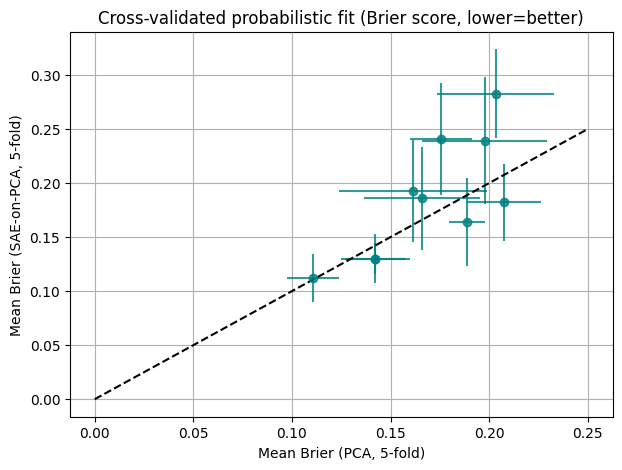

In [7]:
# ================================================================
# 5-FOLD CROSSVALIDATION (NO PCA LEAKAGE) — BRIER SCORE VERSION
# ================================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from skbio.stats.composition import clr
from scipy.special import softmax
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings, pickle

warnings.filterwarnings("ignore")
rng = np.random.default_rng(42)
torch.manual_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ---------------------------------------------------------------
# Load data
# ---------------------------------------------------------------
dat = np.load("/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy")
print("dat shape (neurons × trials):", dat.shape)

path = "/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl"
with open(path, "rb") as f:
    vit_dict = pickle.load(f)["natural_scenes"]

embeddings = np.stack(list(vit_dict))   # (118, 1000)
X = softmax(embeddings, axis=1)
Y_binary = (dat > 0).astype(int)
n_neurons, n_samples = dat.shape
n_images, n_trials = 118, 50
img_ids_full = np.repeat(np.arange(n_images), n_trials)

# ---------------------------------------------------------------
# SAE definition
# ---------------------------------------------------------------
SAE_DIM, SAE_EPOCHS, SAE_BATCH, SAE_LR, SAE_L1 = 100, 60, 256, 1e-3, 1e-3

class SAE(nn.Module):
    def __init__(self, d_in, d_latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_latent), nn.ReLU(inplace=True)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_in)
        )
    def forward(self, x):
        h = self.enc(x)
        return self.dec(h), h

def train_sae(X_train, d_latent=SAE_DIM, epochs=SAE_EPOCHS, batch=SAE_BATCH,
              lr=SAE_LR, l1=SAE_L1):
    d_in = X_train.shape[1]
    model = SAE(d_in, d_latent).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    scaler = StandardScaler().fit(X_train)
    X_std = scaler.transform(X_train)
    dl = DataLoader(TensorDataset(torch.from_numpy(X_std.astype(np.float32))),
                    batch_size=batch, shuffle=True)
    for ep in range(1, epochs+1):
        tot = 0
        for (xb,) in dl:
            xb = xb.to(DEVICE)
            x_hat, h = model(xb)
            loss = mse(x_hat, xb) + l1 * torch.mean(torch.abs(h))
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
        if ep % 20 == 0 or ep == epochs:
            print(f"SAE epoch {ep:3d}/{epochs} | loss={tot/len(dl.dataset):.6f}")
    return model, scaler

@torch.no_grad()
def encode(model, scaler, X):
    X_std = scaler.transform(X)
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    _, h = model(xb)
    return h.cpu().numpy()

# ---------------------------------------------------------------
# Brier Score computation (collapsed by image)
# ---------------------------------------------------------------
def compute_brier_collapsed(y_true, y_pred, img_ids):
    """
    Compute Brier score per image:
    - Collapse by image (mean label and mean predicted prob)
    - Return mean squared difference across images
    """
    df = pd.DataFrame({"img": img_ids, "y": y_true, "p": y_pred})
    agg = df.groupby("img").mean()  # average across trials
    return np.mean((agg["p"] - agg["y"])**2)

# ---------------------------------------------------------------
# Prepare folds and neurons
# ---------------------------------------------------------------
X_clr = clr(X + 1e-12)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
top_pca_neurons = [386, 24940, 28489, 7800, 10412, 26513, 15930, 25807, 27783, 16929]
records = []

# ---------------------------------------------------------------
# Cross-validation with fold-wise PCA and SAE training
# ---------------------------------------------------------------
for nid in top_pca_neurons:
    y_all = Y_binary[nid]
    b_pca_folds, b_sae_folds = [], []

    print(f"\nNeuron {nid} -------------------------")

    for fold_i, (train_img_idx, test_img_idx) in enumerate(kf.split(np.arange(n_images)), 1):
        print(f"\n Fold {fold_i}/5")

        # PCA trained only on training images
        pca_train = PCA()
        pca_train.fit(X_clr[train_img_idx])
        cum_var = np.cumsum(pca_train.explained_variance_ratio_)
        n_components_90 = np.argmax(cum_var >= 0.90) + 1
        pca = PCA(n_components=n_components_90)
        X_train_pca_unique = pca.fit_transform(X_clr[train_img_idx])
        X_test_pca_unique  = pca.transform(X_clr[test_img_idx])

        # Repeat per trial
        X_train_pca = np.repeat(X_train_pca_unique, n_trials, axis=0)
        X_test_pca  = np.repeat(X_test_pca_unique,  n_trials, axis=0)
        train_mask = np.isin(img_ids_full, train_img_idx)
        test_mask  = np.isin(img_ids_full,  test_img_idx)
        y_train, y_test = y_all[train_mask], y_all[test_mask]
        test_img_ids = img_ids_full[test_mask]

        # Train SAE on PCA(train)
        sae_model, sae_scaler = train_sae(X_train_pca_unique)
        Z_train_unique = encode(sae_model, sae_scaler, X_train_pca_unique)
        Z_test_unique  = encode(sae_model,  sae_scaler, X_test_pca_unique)
        Z_train = np.repeat(Z_train_unique, n_trials, axis=0)
        Z_test  = np.repeat(Z_test_unique,  n_trials, axis=0)

        # Logistic regression: PCA
        log_pca = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
        log_pca.fit(X_train_pca, y_train)
        y_pred_pca = log_pca.predict_proba(X_test_pca)[:, 1]
        brier_pca = compute_brier_collapsed(y_test, y_pred_pca, test_img_ids)
        b_pca_folds.append(brier_pca)

        # Logistic regression: SAE
        log_sae = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
        log_sae.fit(Z_train, y_train)
        y_pred_sae = log_sae.predict_proba(Z_test)[:, 1]
        brier_sae = compute_brier_collapsed(y_test, y_pred_sae, test_img_ids)
        b_sae_folds.append(brier_sae)

    records.append({
        "neuron_idx": nid,
        "Brier_PCA_mean": np.nanmean(b_pca_folds),
        "Brier_PCA_std":  np.nanstd(b_pca_folds),
        "Brier_SAE_mean": np.nanmean(b_sae_folds),
        "Brier_SAE_std":  np.nanstd(b_sae_folds),
        "delta_Brier_mean": np.nanmean(np.array(b_sae_folds) - np.array(b_pca_folds))
    })

# ---------------------------------------------------------------
# Results
# ---------------------------------------------------------------
df_cv_brier = pd.DataFrame(records)
print("\n=== 5-Fold Crossvalidated Brier Scores (no PCA leakage) ===")
print(df_cv_brier.round(4))

plt.figure(figsize=(7,5))
plt.errorbar(df_cv_brier["Brier_PCA_mean"], df_cv_brier["Brier_SAE_mean"],
             xerr=df_cv_brier["Brier_PCA_std"], yerr=df_cv_brier["Brier_SAE_std"],
             fmt='o', alpha=0.8, color='teal')
plt.plot([0,0.25],[0,0.25],'k--')
plt.xlabel("Mean Brier (PCA, 5-fold)")
plt.ylabel("Mean Brier (SAE-on-PCA, 5-fold)")
plt.title("Cross-validated probabilistic fit (Brier score, lower=better)")
plt.grid(True)
plt.show()


In [9]:
np.sqrt(0.15)

np.float64(0.3872983346207417)